Generating Fraud Data

In [ ]:
import random

# Define themes and templates
bank_templates = [
    "Your {bank} account has been suspended. Please verify immediately.",
    "Unusual activity detected in your {bank} account. Confirm your identity.",
    "{bank} Security Alert: Immediate verification needed.",
    "Your {bank} online banking access is locked. Reset now.",
]

package_templates = [
    "{carrier} attempted delivery. Pay small fee to reschedule.",
    "{carrier} parcel undeliverable. Update address to receive package.",
    "Delivery failed. {carrier} needs confirmation of your details.",
]

prize_templates = [
    "Congratulations! You've won a {prize}. Claim your reward now.",
    "{prize} awaits you! Confirm your winning entry.",
    "Official notice: You are the lucky winner of a {prize}.",
]

password_templates = [
    "Reset your {service} password now due to suspicious login.",
    "{service} account security compromised. Change password immediately.",
    "Important: Update your {service} credentials today.",
]

ceo_templates = [
    "URGENT: CEO requests immediate payment to new vendor.",
    "Confidential: Process wire transfer as instructed by CFO.",
    "Emergency: Transfer funds to supplier before end of day.",
]

service_templates = [
    "{service} subscription expired. Update billing information.",
    "Your {service} account will be terminated. Verify payment.",
    "{service} service interrupted. Reactivate now.",
]

health_templates = [
    "Healthcare update: Confirm enrollment today.",
    "Urgent: Final notice for health benefits renewal.",
    "Medical insurance requires immediate verification.",
]

# Value pools
banks = ["Bank of America", "Chase", "Wells Fargo", "Citibank", "HSBC"]
carriers = ["FedEx", "UPS", "DHL", "USPS"]
prizes = ["$500 gift card", "$1000 cash prize", "new iPhone", "Amazon voucher"]
services = ["Netflix", "PayPal", "Amazon", "Apple", "Microsoft"]

# Combine all templates
templates = (
    bank_templates +
    package_templates +
    prize_templates +
    password_templates +
    ceo_templates +
    service_templates +
    health_templates
)

# Generate 500 spam messages
spam_messages = []

for _ in range(500):
    template = random.choice(templates)
    filled = template.format(
        bank=random.choice(banks),
        carrier=random.choice(carriers),
        prize=random.choice(prizes),
        service=random.choice(services)
    )
    spam_messages.append(filled)

# Example output
for i in range(10):
    print(f"{i+1}. {spam_messages[i]}")

# Save to text file (optional)
with open("generated_spam_messages.txt", "w") as f:
    for msg in spam_messages:
        f.write(msg + "\n")


1. Unusual activity detected in your HSBC account. Confirm your identity.
2. Unusual activity detected in your HSBC account. Confirm your identity.
3. Confidential: Process wire transfer as instructed by CFO.
4. Healthcare update: Confirm enrollment today.
5. Your Citibank online banking access is locked. Reset now.
6. Congratulations! You've won a $1000 cash prize. Claim your reward now.
7. Unusual activity detected in your Citibank account. Confirm your identity.
8. USPS parcel undeliverable. Update address to receive package.
9. URGENT: CEO requests immediate payment to new vendor.
10. Your Wells Fargo online banking access is locked. Reset now.


In [ ]:
import pandas as pd


# Load original dataset
df_original = pd.read_csv("SMSSpamCollection", sep='\t', names=['label', 'text'])


# Load generated spam messages
with open("generated_spam_messages.txt", "r") as f:
    generated_spam = f.readlines()

# Clean newlines
generated_spam = [msg.strip() for msg in generated_spam]

# Create DataFrame
df_generated = pd.DataFrame({
    'label': ['spam'] * len(generated_spam),
    'text': generated_spam
})

# Combine original + generated
df_full = pd.concat([df_original, df_generated], ignore_index=True)

# Shuffle to mix generated + original
df_full = df_full.sample(frac=1, random_state=42).reset_index(drop=True)

df_full["label"] = df_full["label"].map({"ham": 0, "spam": 1})

print(df_full['label'].value_counts())


label
0    4825
1    1139
Name: count, dtype: int64


Cleaning the text

In [ ]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

df_full['text'] = df_full['text'].apply(clean_text)


Split to traint Test

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import numpy as np
import joblib
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split


# Tokenize text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_full["text"])

sequences = tokenizer.texts_to_sequences(df_full["text"])
padded = pad_sequences(sequences, maxlen=50)

joblib.dump(tokenizer, "tokenizer.pkl")

X_train, X_test, y_train, y_test = train_test_split(
    padded, df_full["label"].values, test_size=0.2, random_state=42
)

# Step 6: Handle class imbalance
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

# Step 7: Build model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=50),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model Training

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict
)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8274 - auc: 0.6823 - loss: 0.6834 - val_accuracy: 0.9505 - val_auc: 0.9895 - val_loss: 0.5354
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9549 - auc: 0.9749 - loss: 0.4959 - val_accuracy: 0.9790 - val_auc: 0.9903 - val_loss: 0.2441
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9835 - auc: 0.9861 - loss: 0.2253 - val_accuracy: 0.9816 - val_auc: 0.9920 - val_loss: 0.1110
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9898 - auc: 0.9966 - loss: 0.1142 - val_accuracy: 0.9782 - val_auc: 0.9928 - val_loss: 0.1149
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9908 - auc: 0.9956 - loss: 0.0818 - val_accuracy: 0.9849 - val_auc: 0.9949 - val_loss: 0.0610
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9922 - auc: 0.9986 - loss: 0.0569 - val_accuracy: 0.9849 - val_auc: 0.9950 - val_loss: 0.0654
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 

Save model

In [ ]:
model.save("smishing_model.h5")


model Evaluation

In [ ]:
# Unpack loss, accuracy, and auc
loss, accuracy, auc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test AUC: {auc:.4f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9850 - auc: 0.9928 - loss: 0.0518
Test Accuracy: 98.83%
Test AUC: 0.9951


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict
# Changed X_test_pad to X_test
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Classification Report
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       985
        spam       0.99      0.94      0.97       208

    accuracy                           0.99      1193
   macro avg       0.99      0.97      0.98      1193
weighted avg       0.99      0.99      0.99      1193

[[983   2]
 [ 12 196]]


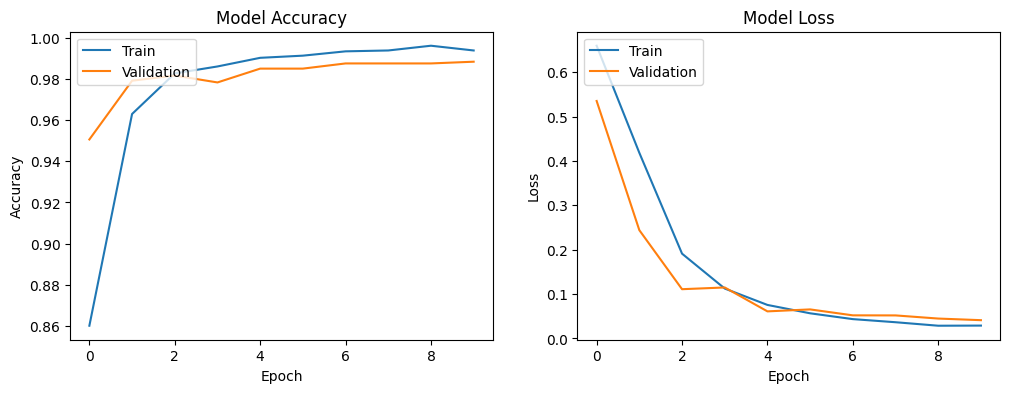

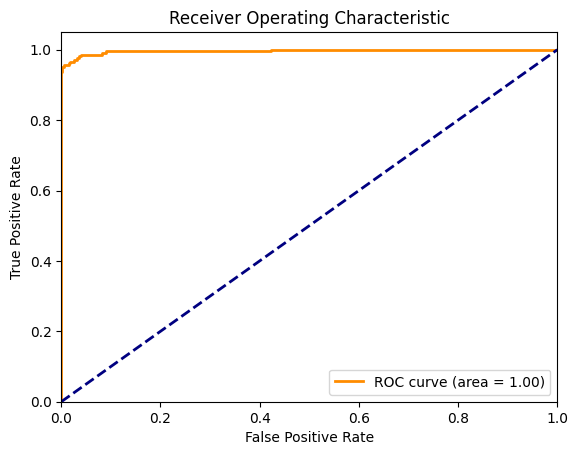

In [ ]:
# prompt: add some curves and plots to show the evaluation of the model

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()